In [19]:
import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from pathlib import Path
import random
import cv2

In [ ]:
# ================= CONFIGURATION =================
# Path to the root directory of the dataset
# Change this path if your dataset folder is elsewhere
DATASET_PATH = "scbdataset"

# Define class names in the same order as your data.yaml file
# Based on previous charts, the order is usually:
CLASS_NAMES = {
    0: "hand-raising",
    1: "read",
    2: "write"
}
# ===============================================

In [ ]:
def count_and_plot(root_dir):
    CLASSES = ["hand-raising", "read", "write"]
    COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Blue, Orange, Green
    print(f"Scanning data from: {root_dir}...")
    
    # 1. Collect label files
    # Find all .txt files in the labels folder (recursive)
    label_files = list(Path(root_dir).glob("**/labels/**/*.txt"))
    
    if not label_files:
        print("No label files found! Please check the path.")
        return

    # Initialize counters
    # instance_counts: Count total bounding boxes (most important for training)
    # image_counts: Count number of images containing at least one of each behavior
    instance_counts = {cls: 0 for cls in CLASSES}
    image_counts = {cls: 0 for cls in CLASSES}

    for lbl_file in label_files:
        try:
            with open(lbl_file, 'r') as f:
                lines = f.readlines()
                
                # Mark which classes are present in this image
                classes_in_this_image = set()
                
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 1:
                        class_id = int(parts[0])
                        if 0 <= class_id < len(CLASSES):
                            class_name = CLASSES[class_id]
                            instance_counts[class_name] += 1
                            classes_in_this_image.add(class_name)
                
                # Update image counts
                for cls in classes_in_this_image:
                    image_counts[cls] += 1
                    
        except Exception as e:
            continue

    # 2. Print results to screen
    print("\n" + "="*50)
    print(f"{'Class Name':<15} | {'Instances (Boxes)':<18} | {'Images Containing':<18}")
    print("-" * 50)
    for cls in CLASSES:
        print(f"{cls:<15} | {instance_counts[cls]:<18} | {image_counts[cls]:<18}")
    print("="*50)
    print(f"Total label files processed: {len(label_files)}")

    # 3. Plot chart (Column Chart)
    plt.figure(figsize=(12, 6))
    
    # Create positions for columns
    x = np.arange(len(CLASSES))
    width = 0.5  # Column width

    # Plot number of Instances (most important metric)
    bars = plt.bar(x, list(instance_counts.values()), width, color=COLORS, alpha=0.8)

    # Add value labels on top of columns
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height}',
                 ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Chart decorations
    plt.xlabel('Behavior Class', fontsize=12)
    plt.ylabel('Number of Instances', fontsize=12)
    plt.title('SCB5 Dataset Distribution (Instances per Class)', fontsize=14, fontweight='bold')
    plt.xticks(x, CLASSES, fontsize=11)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Save chart as image for reports
    output_img = 'dataset_distribution.png'
    plt.savefig(output_img, dpi=300, bbox_inches='tight')
    print(f"\nChart saved to file: {output_img}")
    
    # Show chart
    plt.show()

In [ ]:
def plot_samples(root_dir):
    root_path = Path(root_dir)
    NUM_SAMPLES = 10  # Number of images to display (set to 10)
    CLASSES = ["hand-raising", "read", "write"]
    COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # RGB for each class
    # 1. Get list of all image files
    image_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
    all_images = []
    for ext in image_extensions:
        all_images.extend(list(root_path.glob(f"**/images/**/{ext}")))
    
    if not all_images:
        print("No images found!")
        return

    # 2. Randomly select images
    if len(all_images) < NUM_SAMPLES:
        selected_images = all_images
    else:
        selected_images = random.sample(all_images, NUM_SAMPLES)

    # 3. Plot and display (2 rows, 5 columns for 10 images)
    plt.figure(figsize=(20, 8)) # Increase width for 5 columns
    
    for idx, img_path in enumerate(selected_images):
        # Read image
        img = cv2.imread(str(img_path))
        if img is None: continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w, _ = img.shape
        
        # Find corresponding label file
        label_path = str(img_path).replace("images", "labels").rsplit('.', 1)[0] + ".txt"
        
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        cls_id = int(parts[0])
                        x_center, y_center, width, height = map(float, parts[1:5])
                        
                        # Convert coordinates
                        x1 = int((x_center - width/2) * w)
                        y1 = int((y_center - height/2) * h)
                        x2 = int((x_center + width/2) * w)
                        y2 = int((y_center + height/2) * h)
                        
                        # Draw box & text
                        color = COLORS[cls_id % len(COLORS)]
                        label_name = CLASSES[cls_id] if cls_id < len(CLASSES) else str(cls_id)
                        
                        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                        # Draw smaller text to avoid covering image
                        cv2.putText(img, label_name, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
        
        # Display in subplot (2 rows, 5 columns)
        plt.subplot(2, 5, idx+1) 
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Sample {idx+1}", fontsize=10)

    plt.tight_layout()
    output_file = "data_samples_10_visualized.png"
    plt.savefig(output_file, dpi=150) # Increase DPI for sharper image
    print(f"Saved 10 sample images to file: {output_file}")
    plt.show()

Dang quet du lieu tu: scbdataset...

Class Name      | Instances (Boxes)  | Images Containing 
--------------------------------------------------
hand-raising    | 13453              | 4064              
read            | 24078              | 3878              
write           | 9841               | 1721              
Tong so file nhan da xu ly: 6864

Da luu bieu do vao file: dataset_distribution.png


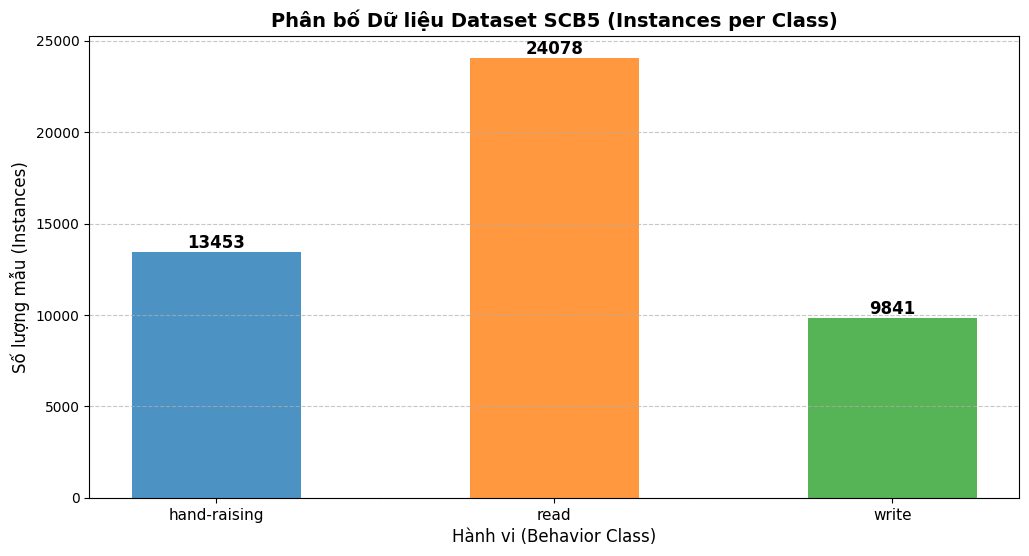

In [15]:
count_and_plot(DATASET_PATH)

Da luu 10 anh mau vao file: data_samples_10_visualized.png


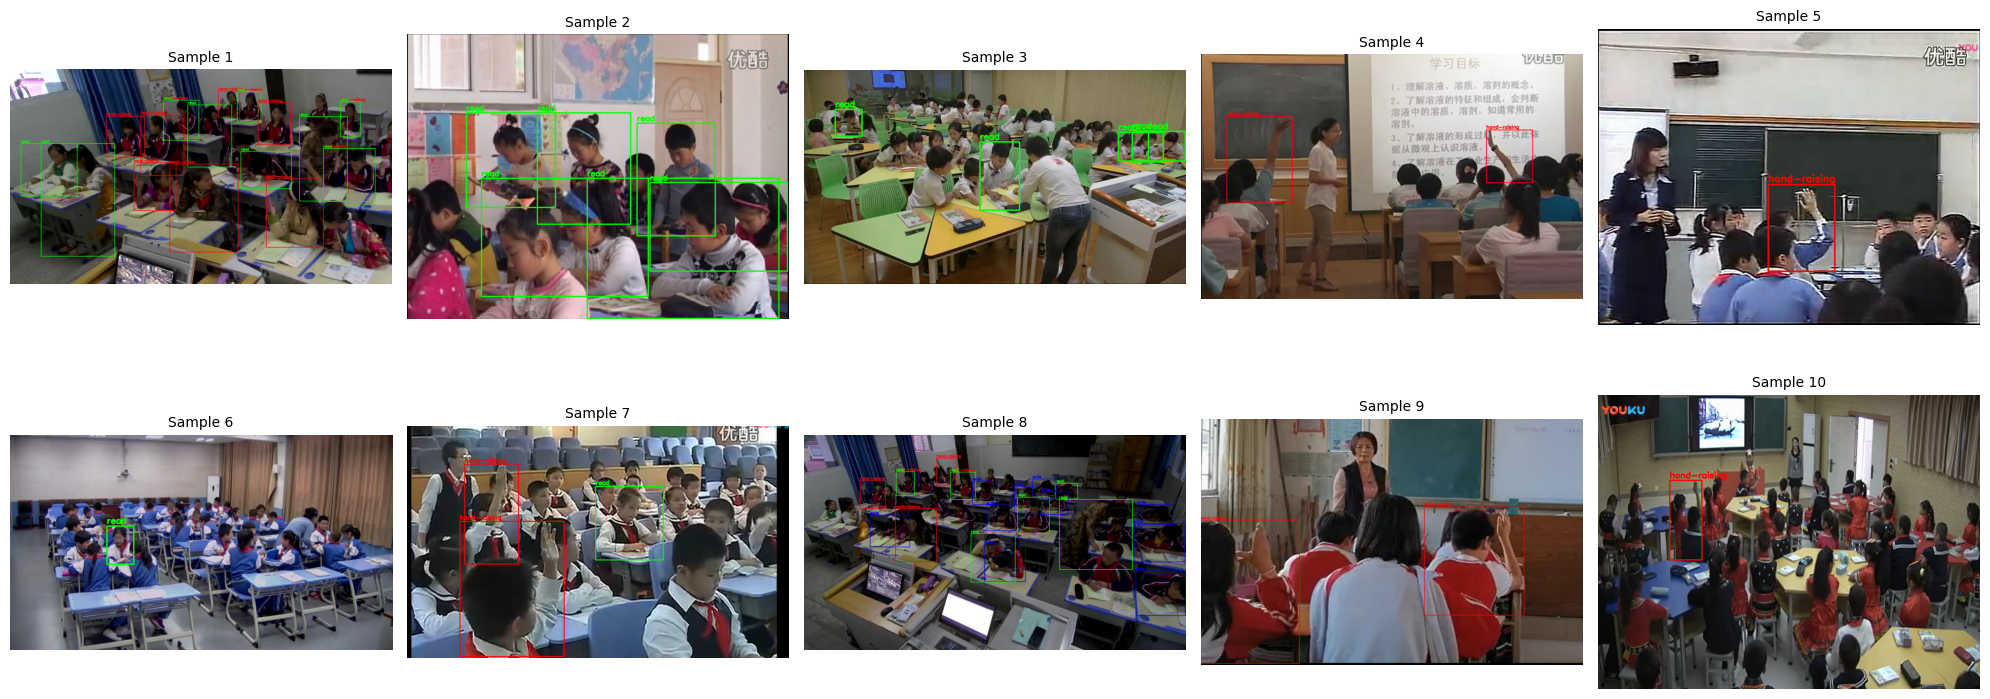

In [32]:
plot_samples(DATASET_PATH)